In [1]:
from IPython.display import FileLink

In [2]:
%load_ext rpy2.ipython

In [3]:
%%R
library(dplyr)
library(ggplot2)
library(phyloseq)
library(RColorBrewer)
library(gridExtra)
library(stats)


Attaching package: ‘dplyr’

The following object is masked from ‘package:stats’:

    filter

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: grid


In [4]:
%%R

asNumeric = function(x) { as.numeric(as.character(x)) }

physeq = import_biom("data/otu_table_wtax.biom", "data/otusn.tree")
sample.data = import_qiime_sample_data("data/ABCD_combined_reads_mapper.tsv")
sample.data$Density = asNumeric(sample.data$Density)
physeq = merge_phyloseq(physeq,sample.data)
physeq.md = sample_data(physeq)
physeq.bulk = prune_samples((physeq.md$Treatment %in% c("12CCPS","13CCPS","12CCSS","13CCSS"))& (physeq.md$Day %in% c(30)) &
                            row.names(physeq.md) %in% grep("bulk", 
                                                           row.names(physeq.md), 
                                                           value=TRUE), physeq)
physeq.bulk = transform_sample_counts(physeq.bulk, function(x) x/sum(x))
physeq.bulk

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 6236 taxa and 4 samples ]
sample_data() Sample Data:       [ 4 samples by 7 sample variables ]
tax_table()   Taxonomy Table:    [ 6236 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 6236 tips and 6235 internal nodes ]


In [5]:
%%R
mdf = psmelt(physeq.bulk)
head(mdf)

         OTU          Sample  Abundance      X.SampleID BarcodeSequence Day
1      OTU.1  13C.PS.30.bulk 0.11972403  13C.PS.30.bulk      TCAGCATCCA  30
3      OTU.1 cont.PS.30.bulk 0.07988981 cont.PS.30.bulk      TCACGTGATC  30
6671  OTU.25  13C.SS.30.bulk 0.02304348  13C.SS.30.bulk      TCAGCATCGT  30
4      OTU.1 cont.SS.30.bulk 0.02035278 cont.SS.30.bulk      TCAGAGACTG  30
4448   OTU.2 cont.SS.30.bulk 0.01990050 cont.SS.30.bulk      TCAGAGACTG  30
18226 OTU.51 cont.PS.30.bulk 0.01803156 cont.PS.30.bulk      TCACGTGATC  30
      Density   LinkerPrimerSequence Treatment     Description    Rank1
1          NA CAGGACTACHVGGGTWTCTAAT    13CCPS  13C.PS.30.bulk Bacteria
3          NA CAGGACTACHVGGGTWTCTAAT    12CCPS cont.PS.30.bulk Bacteria
6671       NA CAGGACTACHVGGGTWTCTAAT    13CCSS  13C.SS.30.bulk Bacteria
4          NA CAGGACTACHVGGGTWTCTAAT    12CCSS cont.SS.30.bulk Bacteria
4448       NA CAGGACTACHVGGGTWTCTAAT    12CCSS cont.SS.30.bulk Bacteria
18226      NA CAGGACTACHVGGGTWTCTAAT

In [6]:
%%R
bulk.mdf = psmelt(physeq.bulk)

In [7]:
%%R
RA.df = bulk.mdf %>%
    group_by(OTU) %>% 
    summarize(mean.abund = mean(Abundance), 
              max.abund = max(Abundance), 
              min.abund = min(Abundance))

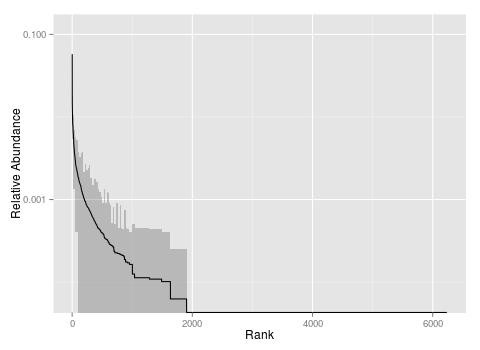

In [8]:
%%R -h 350
RA.df.sorted = RA.df[order(-RA.df$mean.abund, -RA.df$max.abund),]
RA.df.sorted$Rank = 1:nrow(RA.df.sorted)

p = ggplot(RA.df.sorted, aes(y = mean.abund, x = Rank))
p = p + geom_ribbon(aes(ymax = max.abund, ymin = min.abund), alpha = 0.25)
p = p + geom_line()
p = p + scale_y_log10()
p = p + labs(y = "Relative Abundance")

p

###This file is from the [sparsity notebook](./Sparsity_make_l2fc_table.ipynb).

In [9]:
%%R
df_all = read.table("data/l2fc_table.csv", 
                    header = TRUE,
                    sep = ",")
head(df_all)

  sparsity_threshold Day Treatment     OTU log2FoldChange            p    Rank1
1               0.55  30    13CCSS OTU.783     -0.3370825 9.965741e-01 Bacteria
2               0.55  30    13CCSS  OTU.79      0.7598182 4.889860e-01 Bacteria
3               0.55  30    13CCSS OTU.304      0.4183648 8.089837e-01 Bacteria
4               0.55  30    13CCSS  OTU.50      0.7289694 5.252368e-01 Bacteria
5               0.55  30    13CCSS OTU.382      2.9833574 1.370092e-07 Bacteria
6               0.55  30    13CCSS OTU.465      0.5515994 6.887540e-01 Bacteria
          Rank2      Rank3        Rank4         Rank5       Rank6
1 Acidobacteria Holophagae      Sva0725          <NA>        <NA>
2 Bacteroidetes Cytophagia Cytophagales Cytophagaceae Flexibacter
3 Bacteroidetes Cytophagia Cytophagales Cytophagaceae Flexibacter
4 Bacteroidetes Cytophagia Cytophagales Cytophagaceae Flexibacter
5 Bacteroidetes Cytophagia Cytophagales Cytophagaceae Flexibacter
6 Bacteroidetes Cytophagia Cytophagales Cyto

In [10]:
%%R
FDR = 0.1
ds = subset(df_all, (padj <= FDR))
p = as.character(levels(factor(ds$Rank2)))
quote(paste("italic(", p, ")", sep=""))

[1] "italic(Acidobacteria)"   "italic(Bacteroidetes)"  
[3] "italic(Chloroflexi)"     "italic(Cyanobacteria)"  
[5] "italic(Planctomycetes)"  "italic(Proteobacteria)" 
[7] "italic(Spirochaetes)"    "italic(Verrucomicrobia)"


In [11]:
%%R
t = parse(text = paste("italic(", p, ")", sep=""))

Joining by: "OTU"
Joining by: "OTU"


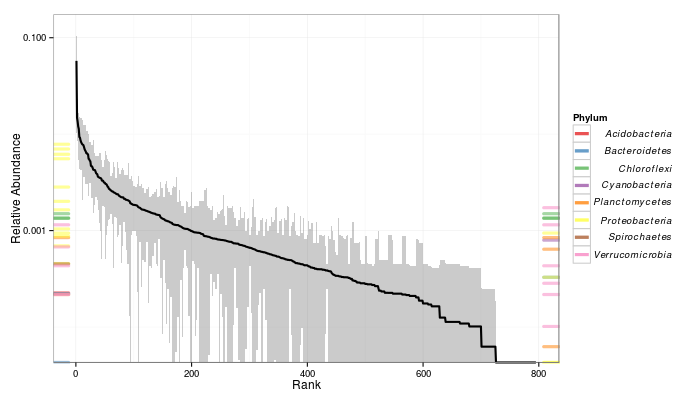

In [12]:
%%R -h 400 -w 700

colours = c("#377eb8", "#4daf4a")
getPalette = colorRampPalette(brewer.pal(8, "Set1"))

FDR = 0.10

tax = data.frame(tax_table(physeq.bulk))
tax$OTU = rownames(tax)

df_all$padj = p.adjust(df_all$p, method = "BH")

OTUs.wP = unique(df_all$OTU)

RA.df.wP = subset(RA.df, OTU %in% OTUs.wP)

RA.df.wP.sorted = RA.df.wP[order(-RA.df.wP$mean.abund, -RA.df.wP$max.abund),]
RA.df.wP.sorted$Rank = 1:nrow(RA.df.wP.sorted)

df_all.p.summarize = df_all %>% 
    group_by(OTU, Treatment) %>%
    summarize(p.adj.min = min(padj))

df_all.p.summarize = left_join(df_all.p.summarize, RA.df.wP.sorted)
df_all.p.summarize = left_join(df_all.p.summarize, tax)

#d = RA.df.wP.sorted
d = df_all.p.summarize
d$jitter = 1 + runif(nrow(d), min = 0.25, max = 2.5)

p = ggplot(d, aes(y = mean.abund, x = Rank))
p = p + geom_ribbon(aes(ymax = max.abund, ymin = min.abund), alpha = 0.25)

p = p + geom_rug(data = subset(d, (p.adj.min <= FDR)&(Treatment=="13CCSS")), 
                 sides = "l", aes(color = Rank2), size = 1.5, alpha = 0.5)
p = p + geom_rug(data = subset(d, (p.adj.min <= FDR)&(Treatment=="13CCPS")), 
                 sides = "r", aes(color = Rank2), size = 1.5, alpha = 0.5)

p = p + geom_line(size = 1)

p = p + scale_color_manual(values=getPalette(8), labels = t)

p = p + scale_y_log10()
p = p + labs(y = "Relative Abundance", color = "Phylum")

p = p + theme_bw()

p = p + guides(fill = guide_legend(label.hjust = 0))

p.rabund = p

p

In [13]:
%%R
PS.mean_abund = subset(df_all.p.summarize, (p.adj.min <= FDR)&(Treatment=="13CCPS"))$mean.abund
SS.mean_abund = subset(df_all.p.summarize, (p.adj.min <= FDR)&(Treatment=="13CCSS"))$mean.abund

wilcox.test(SS.mean_abund, PS.mean_abund, alternative = "less")


	Wilcoxon rank sum test with continuity correction

data:  SS.mean_abund and PS.mean_abund
W = 305, p-value = 0.9562
alternative hypothesis: true location shift is less than 0



###These files are from the density shift notebooks [1](./Density_shiftsPS.ipynb) and [2](./Density_shiftsSS.ipynb).

#### The PS density shift was subsetted into just D30 since that is the only time point I'm comparing PS with SS.  

In [14]:
%%R
df.shifts.PS = read.csv("data/density_shifts_PS_D30.csv", sep = ",", header = TRUE, )
df.shifts.PS$shift = as.numeric(as.character(df.shifts.PS$shift))
head(df.shifts.PS)

       OTU        shift Day Treatment
1  OTU.759  0.007532155  30    13CCPS
2  OTU.758 -0.002040173  30    13CCPS
3  OTU.757 -0.017384451  30    13CCPS
4  OTU.756 -0.015844569  30    13CCPS
5 OTU.5419  0.006751877  30    13CCPS
6  OTU.839           NA  30    13CCPS


In [15]:
%%R
df.shifts.SS = read.csv("data/density_shifts_SS.csv", sep = ",", header = TRUE, )
df.shifts.SS$shift = as.numeric(as.character(df.shifts.SS$shift))
head(df.shifts.SS)

       OTU         shift Day Treatment
1  OTU.759 -0.0142495910  30    13CCSS
2  OTU.758 -0.0006618842  30    13CCSS
3  OTU.757 -0.0082880312  30    13CCSS
4  OTU.756  0.0058375192  30    13CCSS
5 OTU.5419 -0.0105358313  30    13CCSS
6  OTU.839  0.0123829002  30    13CCSS


In [16]:
%%R
density_shift_allD30 = rbind(df.shifts.PS, df.shifts.SS)
head(density_shift_allD30)

       OTU        shift Day Treatment
1  OTU.759  0.007532155  30    13CCPS
2  OTU.758 -0.002040173  30    13CCPS
3  OTU.757 -0.017384451  30    13CCPS
4  OTU.756 -0.015844569  30    13CCPS
5 OTU.5419  0.006751877  30    13CCPS
6  OTU.839           NA  30    13CCPS


In [17]:
%%R
write.csv(density_shift_allD30, "data/density_shifts_allD30.csv")

In [18]:
!head data/density_shifts_allD30.csv

"","OTU","shift","Day","Treatment"
"1","OTU.759",0.007532155,30,"13CCPS"
"2","OTU.758",-0.002040173,30,"13CCPS"
"3","OTU.757",-0.017384451,30,"13CCPS"
"4","OTU.756",-0.015844569,30,"13CCPS"
"5","OTU.5419",0.006751877,30,"13CCPS"
"6","OTU.839",NA,30,"13CCPS"
"7","OTU.1968",-0.012578331,30,"13CCPS"
"8","OTU.1969",NA,30,"13CCPS"
"9","OTU.1964",-0.00314436,30,"13CCPS"


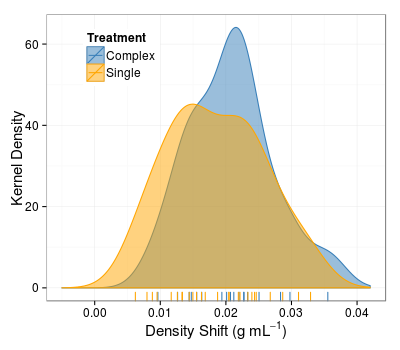

In [19]:
%%R -w 400 -h 350
df_all.wShifts = merge(df_all, density_shift_allD30, by = c("OTU","Day","Treatment"))

df.plot = subset(df_all.wShifts, padj <= FDR)

colours = c("#377eb8","orange")

p = ggplot(df.plot, aes(x = as.numeric(as.character(shift))))

p = p + geom_density(aes(color = Treatment, fill = Treatment), alpha = 0.50)
p = p + geom_rug(aes(color = Treatment))
p = p + scale_color_manual(values=colours,
                           breaks=c("13CCPS", "13CCSS"),
                            labels=c("Complex", "Single")) 
p = p + scale_fill_manual(values=colours,
                          breaks=c("13CCPS", "13CCSS"),
                            labels=c("Complex", "Single"))
p = p + labs(y = "Kernel Density", x =  expression(paste("Density Shift (g mL",{}^-1,")",sep="")))
p = p + xlim(xmin = -0.005, xmax = 0.042)

p = p + theme_bw()
p = p + theme(axis.title.y = element_text(size=15))
p = p + theme(axis.title.x = element_text(size=15))
p = p + theme(axis.text.x = element_text(size=12))
p = p + theme(axis.text.y = element_text(size=12))
p = p + theme(legend.title = element_text(size = 12), legend.text = element_text(size = 12))
p = p + theme(legend.position=c(0.22,0.85))

p.shift1 = p 

p

In [20]:
%%R
PS.shifts = subset(df_all.wShifts, (Treatment == "13CCPS")&(padj <= FDR))$shift
SS.shifts = subset(df_all.wShifts, (Treatment == "13CCSS")&(padj <= FDR))$shift

wilcox.test(PS.shifts, SS.shifts, alternative = "greater")


	Wilcoxon rank sum test

data:  PS.shifts and SS.shifts
W = 276, p-value = 0.1627
alternative hypothesis: true location shift is greater than 0



NULL


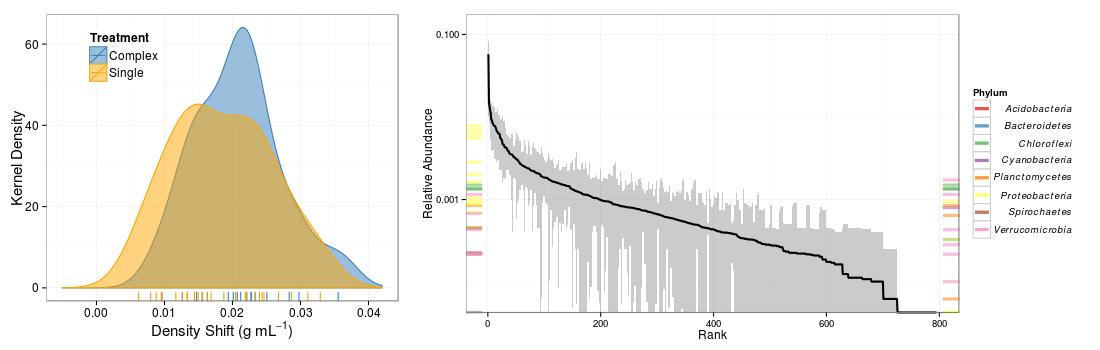

In [21]:
%%R -w 1100 -h 350

p.combined = grid.arrange(p.shift1, p.rabund, widths = c(1.2, 2), ncol = 2)

p.combined

In [22]:
%%R
pdf("figs/shift_and_rabund.pdf", w = 15, h = 4)
print(grid.arrange(p.shift1, p.rabund, widths = c(1.2, 2), ncol = 2))
dev.off()

NULL
png 
  2 


In [23]:
%%R
png("figs/shift_and_rabund.png", w = 15, h = 4, units = "in", res = 600)
print(grid.arrange(p.shift1, p.rabund, widths = c(1.2, 2), ncol = 2))
dev.off()

NULL
png 
  2 


In [24]:
FileLink("figs/shift_and_rabund.pdf")

/home/ashley/single_substrate/figs/shift_and_rabund.pdf

In [25]:
FileLink("figs/shift_and_rabund.png")

/home/ashley/single_substrate/figs/shift_and_rabund.png

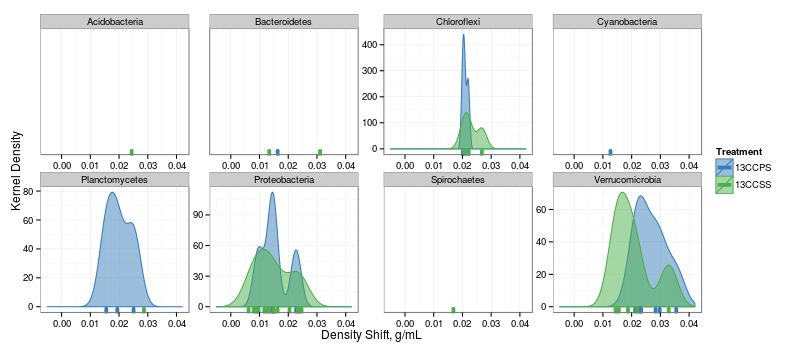

In [26]:
%%R -w 800 -h 350
df_all.wShifts = merge(df_all, density_shift_allD30, by = c("OTU","Day","Treatment"))

df.plot = subset(df_all.wShifts, padj <= FDR)

colours = c("#377eb8", "#4daf4a")

p2 = ggplot(df.plot, aes(x = as.numeric(as.character(shift))))

p2 = p2 + facet_wrap(~Rank2, ncol=4, scales = "free")
p2 = p2 + geom_density(aes(color = Treatment, fill = Treatment), alpha = 0.50)
p2 = p2 + geom_rug(aes(color = Treatment), size = 1.8)
p2 = p2 + scale_color_manual(values=colours) 
p2 = p2 + scale_fill_manual(values=colours)
p2 = p2 + labs(y = "Kernel Density", x = "Density Shift, g/mL")
p2 = p2 + xlim(xmin = -0.005, xmax = 0.042)
p2 = p2 + theme_bw()

p2

In [27]:
%%R
pdf("figs/KDE_byPhylum_panel.pdf", w = 10, h = 4)
grid.arrange(p2, ncol = 1)
dev.off()

png 
  2 


In [28]:
%%R
png("figs/KDE_byPhylum_panel.png", w = 15, h = 4, units = "in", res = 600)
grid.arrange(p2, ncol = 1)
dev.off()

png 
  2 


In [29]:
FileLink("figs/KDE_byPhylum_panel.pdf")

/home/ashley/single_substrate/figs/KDE_byPhylum_panel.pdf

In [30]:
FileLink("figs/KDE_byPhylum_panel.png")

/home/ashley/single_substrate/figs/KDE_byPhylum_panel.png

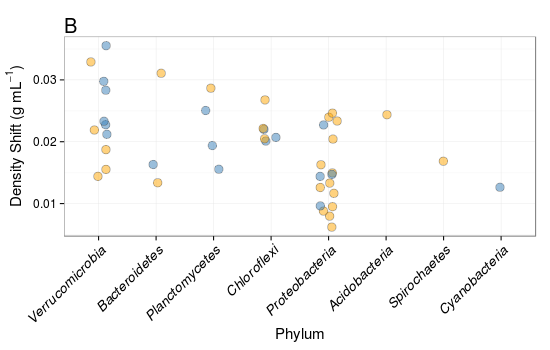

In [31]:
%%R -w 550 -h 350
df_all.wShifts = merge(df_all, density_shift_allD30, by = c("OTU","Day","Treatment"))

df.plot = subset(df_all.wShifts, padj <= FDR)

d = df.plot %>%
    group_by(Rank2) %>%
    summarize(max.shift = max(shift)) %>%
    arrange(desc(max.shift))

order = d$Rank2

df.plot$Rank2 = factor(df.plot$Rank2, levels = order)

colours = c("#377eb8","orange")

p3 = ggplot(df.plot, aes(x = Rank2, y = shift, fill = Treatment))

p3 = p3 + geom_point(shape = 21, size = 4, alpha = 0.5, position = position_jitter(w = 0.15), color = "gray33")

p3 = p3 + theme_bw()

p3 = p3 + theme(axis.text.x = element_text(size = 14, angle = 45, hjust = 1, face = "italic"))

p3 = p3 + labs(y = expression(paste("Density Shift (g mL",{}^-1,")",sep="")), x = "Phylum")

p3 = p3 + theme(axis.title.y = element_text(size = 15, vjust = 1.25))

p3 = p3 + theme(axis.title.x = element_text(size = 15))

p3 = p3 + scale_fill_manual(values=colours,
                            breaks=c("13CCPS", "13CCSS"),
                            labels=c("Carbon Mixture", "Cellulose Only")) 
#p3 = p3 + theme(legend.text = element_text(size = 11))

#p3 = p3 + theme(legend.title = element_text(size = 11))

p3 = p3 + ggtitle("B")
p3 = p3 + theme(plot.title = element_text(hjust = 0, size = 20))
p3 = p3 + theme(legend.position = "none")
#p3 = p3 + theme(axis.title.y = element_text(size=15))
#p3 = p3 + theme(axis.title.x = element_text(size=15))
#p3 = p3 + theme(axis.text.x = element_text(size=12))
p3 = p3 + theme(axis.text.y = element_text(size=12))
#p3 = p3 + theme(legend.title = element_text(size = 13), legend.text = element_text(size = 13))
#p3 = p3 + theme(legend.position=c(0.2,0.8))

p3

In [32]:
%%R
ggsave("figs/BDshift_scatter_phylum.png", p3, h = 4, w = 6)

In [33]:
FileLink("figs/BDshift_scatter_phylum.png")

/home/ashley/single_substrate/figs/BDshift_scatter_phylum.png

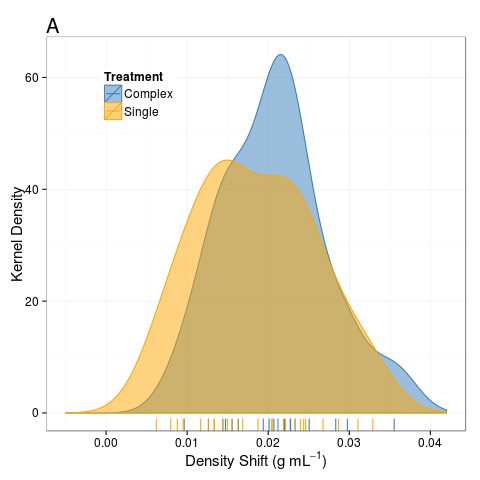

In [34]:
%%R
p4 = p.shift1 + ggtitle("A")
p4 = p4 + theme(plot.title = element_text(hjust = 0, size = 20))
p4

NULL


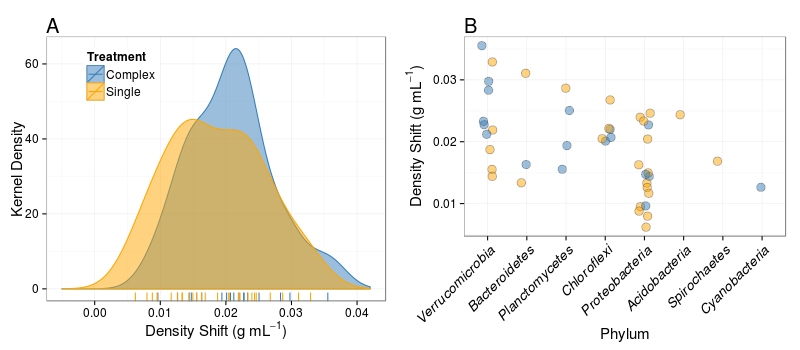

In [35]:
%%R -w 800 -h 350

density.shifts = grid.arrange(p4, p3, widths = c(0.9, 0.9),heights = c(1, 1.5), ncol = 2)

density.shifts

In [36]:
%%R
pdf("figs/shift_all_andby_phylum.pdf", w = 10, h = 4)
print(grid.arrange(p4, p3, widths = c(0.9, 0.9), heights = c(1, 1.5), ncol = 2))
dev.off()

NULL
png 
  2 


In [37]:
FileLink("figs/shift_all_andby_phylum.pdf")

/home/ashley/single_substrate/figs/shift_all_andby_phylum.pdf

In [38]:
%%R
png("figs/shift_all_andby_phylum.png", w = 10, h = 4, units = "in", res = 600)
print(grid.arrange(p4, p3, widths = c(0.9, 0.9), heights = c(1, 1.5), ncol = 2))
dev.off()

NULL
png 
  2 


In [39]:
FileLink("figs/shift_all_andby_phylum.png")

/home/ashley/single_substrate/figs/shift_all_andby_phylum.png

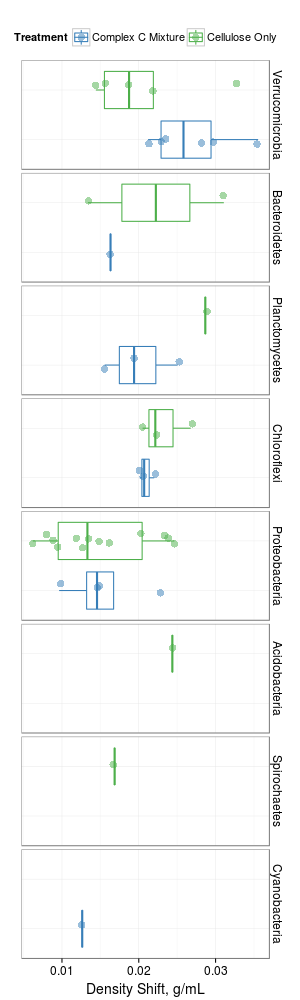

In [40]:
%%R -w 300 -h 1000
df_all.wShifts = merge(df_all, density_shift_allD30, by = c("OTU","Day","Treatment"))

df.plot = subset(df_all.wShifts, padj <= FDR)

d = df.plot %>%
    group_by(Rank2) %>%
    summarize(max.shift = max(shift)) %>%
    arrange(desc(max.shift))

order = d$Rank2

df.plot$Rank2 = factor(df.plot$Rank2, levels = order)

colours = c("#377eb8", "#4daf4a")

p4 = ggplot(df.plot, aes(x = Treatment, y = shift, color = Treatment))

p4 = p4 + facet_grid(Rank2~.)

p4 = p4 + coord_flip()

p4 = p4 + geom_boxplot(outlier.shape = NA)

p4 = p4 + geom_point(size = 3.5, alpha = 0.5, position = position_jitter(w = 0.15))

p4 = p4 + theme_bw()

p4 = p4 + theme(axis.text.x = element_text(size = 12))

p4 = p4 + theme(axis.text.y = element_blank())

p4 = p4 + labs(y = "Density Shift, g/mL")

p4 = p4 + theme(axis.title.x = element_text(size = 14, vjust = -0.2))

p4 = p4 + theme(axis.title.y = element_blank())

p4 = p4 + scale_color_manual(values=colours,
                            breaks=c("13CCPS", "13CCSS"),
                            labels=c("Complex C Mixture", "Cellulose Only")) 
p4 = p4 + theme(legend.text = element_text(size = 11))

p4 = p4 + theme(legend.title = element_text(size = 11))

p4 = p4 + theme(strip.text = element_text(size=12))

p4 = p4 + theme(strip.background = element_blank())

p4 = p4 + theme(legend.position="top")

p4 = p4 + theme(axis.ticks.y = element_blank())

p4

In [41]:
%%R
ggsave("figs/BDshift_boxplot_phylum.png", p4, h = 12, w = 4)

In [42]:
FileLink("figs/BDshift_boxplot_phylum.png")

/home/ashley/single_substrate/figs/BDshift_boxplot_phylum.png

In [43]:
%%R
PS.shifts = subset(df_all.wShifts, (Treatment == "13CCPS")&(padj <= FDR)&(Rank2 == "Bacteroidetes"))$shift
SS.shifts = subset(df_all.wShifts, (Treatment == "13CCSS")&(padj <= FDR)&(Rank2 == "Bacteroidetes"))$shift

wilcox.test(PS.shifts, SS.shifts, alternative = "less")


	Wilcoxon rank sum test

data:  PS.shifts and SS.shifts
W = 1, p-value = 0.6667
alternative hypothesis: true location shift is less than 0



In [44]:
%%R
PS.shifts = subset(df_all.wShifts, (Treatment == "13CCPS")&(padj <= FDR)&(Rank2 == "Chloroflexi"))$shift
SS.shifts = subset(df_all.wShifts, (Treatment == "13CCSS")&(padj <= FDR)&(Rank2 == "Chloroflexi"))$shift

wilcox.test(PS.shifts, SS.shifts, alternative = "greater")


	Wilcoxon rank sum test

data:  PS.shifts and SS.shifts
W = 2, p-value = 0.9
alternative hypothesis: true location shift is greater than 0



In [45]:
%%R
PS.shifts = subset(df_all.wShifts, (Treatment == "13CCPS")&(padj <= FDR)&(Rank2 == "Planctomycetes"))$shift
SS.shifts = subset(df_all.wShifts, (Treatment == "13CCSS")&(padj <= FDR)&(Rank2 == "Planctomycetes"))$shift

wilcox.test(PS.shifts, SS.shifts, alternative = "less")


	Wilcoxon rank sum test

data:  PS.shifts and SS.shifts
W = 0, p-value = 0.25
alternative hypothesis: true location shift is less than 0



In [46]:
%%R
PS.shifts = subset(df_all.wShifts, (Treatment == "13CCPS")&(padj <= FDR)&(Rank2 == "Proteobacteria"))$shift
SS.shifts = subset(df_all.wShifts, (Treatment == "13CCSS")&(padj <= FDR)&(Rank2 == "Proteobacteria"))$shift

wilcox.test(PS.shifts, SS.shifts, alternative = "greater")


	Wilcoxon rank sum test

data:  PS.shifts and SS.shifts
W = 28, p-value = 0.4353
alternative hypothesis: true location shift is greater than 0



In [47]:
%%R
PS.shifts = subset(df_all.wShifts, (Treatment == "13CCPS")&(padj <= FDR)&(Rank2 == "Verrucomicrobia"))$shift
SS.shifts = subset(df_all.wShifts, (Treatment == "13CCSS")&(padj <= FDR)&(Rank2 == "Verrucomicrobia"))$shift

wilcox.test(PS.shifts, SS.shifts, alternative = "greater")


	Wilcoxon rank sum test

data:  PS.shifts and SS.shifts
W = 24, p-value = 0.06277
alternative hypothesis: true location shift is greater than 0



In [48]:
%%R
PS.shifts = subset(df_all.wShifts, (Treatment == "13CCPS")&(padj <= FDR)&(Rank5 == "FukuN18_freshwater_group"))$shift
SS.shifts = subset(df_all.wShifts, (Treatment == "13CCSS")&(padj <= FDR)&(Rank5 == "FukuN18_freshwater_group"))$shift

wilcox.test(PS.shifts, SS.shifts, alternative = "greater")


	Wilcoxon rank sum test

data:  PS.shifts and SS.shifts
W = 9, p-value = 0.05
alternative hypothesis: true location shift is greater than 0



In [49]:
%%R
PS.shifts = subset(df_all.wShifts, (Treatment == "13CCPS")&(padj <= FDR)&(Rank4 == "Rhizobiales"))$shift
SS.shifts = subset(df_all.wShifts, (Treatment == "13CCSS")&(padj <= FDR)&(Rank4 == "Rhizobiales"))$shift

wilcox.test(PS.shifts, SS.shifts, alternative = "less")


	Wilcoxon rank sum test

data:  PS.shifts and SS.shifts
W = 4, p-value = 0.6
alternative hypothesis: true location shift is less than 0



In [50]:
%%R
PS.shifts = subset(df_all.wShifts, (Treatment == "13CCPS")&(padj <= FDR)&(Rank4 == "Planctomycetales"))$shift
SS.shifts = subset(df_all.wShifts, (Treatment == "13CCSS")&(padj <= FDR)&(Rank4 == "Planctomycetales"))$shift

wilcox.test(PS.shifts, SS.shifts, alternative = "greater")


	Wilcoxon rank sum test

data:  PS.shifts and SS.shifts
W = 0, p-value = 1
alternative hypothesis: true location shift is greater than 0

